### Test case LVV-T1843: Verify calculation of significance of imperfect crosstalk corrections

Verify that the DM system provides software to assess whether the maximum local significance integrated over the PSF of imperfect crosstalk corrections is less than **Xtalk = 3 sigma**.

**Discussion:** The **Xtalk** metric is defined as "the maximum local significance integrated over the PSF of imperfect crosstalk corrections." To test this requirement, we will identify bright stars on various LSSTComCam processed exposures to check for crosstalk residuals at the expected target locations. This will provide an estimate of the **Xtalk** value.


This section will scan for crosstalk residuals at expected locations, and will compile a table, `intra_detector_catalog`, containing residual analysis within the same detector as the source creating the crosstalk.
This catalog is written to disk, so the exposure scan can be skipped to make things run faster.

In [1]:
# Standard imports
import copy
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from astropy.coordinates import SkyCoord
import astropy.units as u
from astroquery.gaia import Gaia
from astropy.table import Table
import lsst.afw.display as afwDisplay
from lsst.daf.butler import Butler, DatasetNotFoundError
from lsst.afw.cameraGeom import ReadoutCorner
import lsst.geom as geom

from mpl_toolkits.axes_grid1 import make_axes_locatable

Initialize the butler, and define the collection (corresponding to w_2025_10 processing) we will use.

In [2]:
INSTRUMENT = "LSSTComCam"
COLLECTION = "LSSTComCam/runs/DRP/DP1/w_2025_10/DM-49359"
butler = Butler("/repo/main")

### Retrieve bright stars from Gaia

Create a function that queries the Gaia DR3 catalog for bright stars, using a cone search about a specified RA, Dec position.

In [3]:
def get_bright_gaia_stars(skycoord, radius=1.0, maglim=8.0):
    """Execute a cone search from Gaia DR3 about a specified position,
       retrieving all sources brighter than a limiting magnitude.

    Parameters
    ----------
    skycoord : Astropy `SkyCoord` object
        Center position for the cone search.
    radius : `float`
        Radius in degrees to search. Default: 1.0 deg.
    maglim : `float`
        Magnitude limit for search, in Gaia G mag. Default: 8.0.

    Returns
    -------
    gaia_cat : Astropy `Table`
         Table of Gaia measurements within the specified cone.
    """

    job = Gaia.launch_job_async(f"SELECT ra, dec, phot_g_mean_mag, DISTANCE({skycoord.ra.deg}, {skycoord.dec.deg}, ra, dec) AS ang_sep \
                                FROM gaiadr3.gaia_source WHERE DISTANCE({skycoord.ra.deg}, {skycoord.dec.deg}, ra, dec) < {radius} \
                                AND phot_g_mean_mag < {maglim} \
                                ORDER BY phot_g_mean_mag ASC")
    gaia_cat = job.get_results()
    return gaia_cat

Search around the central coordinates of four fields observed frequently during ComCam on-sky campaigns.

In [4]:
center_coords = {"ECDFS": (53.13, -28.10),
                 "EDFS": (59.10, -48.73),
                 "Rubin_SV_95_-25": (95.00, -25.00),
                 "Rubin_SV_38_7": (37.86, 6.98)
                }

In [5]:
bright_star_tables = {}

for field in center_coords.keys():
    rr, dd = center_coords[field]
    sc = SkyCoord(ra=rr*u.deg, dec=dd*u.deg, frame='icrs')

    tab = get_bright_gaia_stars(sc, maglim=7.8, radius=0.5)
    bright_star_tables[field] = tab

for key in bright_star_tables.keys():
    print(key, bright_star_tables[key])

INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]


ECDFS         ra               dec        phot_g_mean_mag      ang_sep      
       deg               deg              mag                         
----------------- ----------------- --------------- ------------------
52.66809100336391 -27.9215393549127       7.7354326 0.4451394610172921
EDFS         ra                dec         phot_g_mean_mag       ang_sep      
       deg                deg               mag                          
----------------- ------------------- --------------- -------------------
59.21392814230366 -48.478592045879886       7.0150785 0.26245260597673004
Rubin_SV_95_-25         ra                dec         phot_g_mean_mag       ang_sep      
       deg                deg               mag                          
----------------- ------------------- --------------- -------------------
94.73159883524747 -25.012726329400653        7.013944 0.24357411776683183
 94.8136400244342 -24.974892882913373       7.3479795 0.17077245165162522
Rubin_SV_38_7         r

### Query for datasets overlapping each bright star

Query the butler for `calexp` images overlapping the positions of each bright star. For expediency, subselect from these images. Identify the (x, y) position of the bright star on each of the images, and retain this along with the visit and detector numbers.

In [6]:
def make_bright_stars_catalog(bright_star_tables, percent_to_keep=100.0):
    """Given a dict containing tables retrieved from Gaia, query the butler
       for calexp images overlapping all stars in the input tables.

    Parameters
    ----------
    bright_star_tables : `dict` of Astropy `Tables`
        Dict keyed on field names, containing tables returned by
        get_bright_gaia_stars.
    percent_to_keep : `float`
        Percentage of query results to keep (from 0-100%). Default: 100.0 percent.

    Returns
    -------
    bright_stars_list : `list` of `tuples`
         List containing visit and detector IDs, and xy positions, of
         stars from the input tables.
    """
    bright_stars_list = []
    for field in bright_star_tables.keys():
        print(f"\nField: {field}\n")
        tab = bright_star_tables[field]
        for star in tab:
            rr = star['ra']
            dd = star['dec']
            
            datasetRefs = butler.query_datasets("calexp", collections=COLLECTION,
                                                where="visit_detector_region.region OVERLAPS POINT(ra, dec)",
                                                bind={"ra": rr, "dec": dd}, with_dimension_records=True)

            print(f"Found {len(datasetRefs)} refs at (ra, dec) = ({rr}, {dd})")
            subsetRefs = np.random.choice(datasetRefs, size=int((percent_to_keep/100)*len(datasetRefs)), replace=False)
            print(f"Keeping {len(subsetRefs)}")
            radec = geom.SpherePoint(rr*geom.degrees, dd*geom.degrees)
            # for ref in datasetRefs:
            for ref in subsetRefs:
                wcs = butler.get(ref.makeComponentRef('wcs'))
                xy = wcs.skyToPixel(radec)
                bright_stars_list.append((ref.dataId['visit'],
                                          ref.dataId['detector'],
                                          [xy.x, xy.y])
                                        )
    return bright_stars_list
            

In [7]:
# Keep 25% of the images.
bright_star_catalog = make_bright_stars_catalog(bright_star_tables, percent_to_keep=25.0)


Field: ECDFS

Found 236 refs at (ra, dec) = (52.66809100336391, -27.9215393549127)
Keeping 59

Field: EDFS

Found 266 refs at (ra, dec) = (59.21392814230366, -48.478592045879886)
Keeping 66

Field: Rubin_SV_95_-25

Found 293 refs at (ra, dec) = (94.73159883524747, -25.012726329400653)
Keeping 73
Found 330 refs at (ra, dec) = (94.8136400244342, -24.974892882913373)
Keeping 82

Field: Rubin_SV_38_7

Found 48 refs at (ra, dec) = (38.05070234190872, 6.717251751698278)
Keeping 12


In [8]:
len(bright_star_catalog)

292

In [9]:
# Define utility functions for this crosstalk study:
def position_to_amp(position, detector):
    """Convert a LSST assembled image location to an amplifier and list of crosstalk-centers.

    Parameters
    ----------
    position : `tuple` (`float`, `float)
         Source position.
    detector : `lsst.afw.cameraGeom.Detector`
         Detector to use for geometry.  This is best taken
         from the exposure to be studied.

    Returns
    -------
    amplifier : `str`
         Amplifier of source.
    copositions : `list` (`tuple` (`float`, `float`))
         List of alternate crosstalk locations.
    """
    x, y = position
    sourceAmp = None
    associatedPositions = []
    for amp in detector:
        ampBox = amp.getBBox()
        if ampBox.contains(x, y):
            sourceAmp = amp.getName()
            if amp.getReadoutCorner() == ReadoutCorner.UR:
                vector = (ampBox.maxX - x, ampBox.maxY - y)
            elif amp.getReadoutCorner() == ReadoutCorner.LR:
                vector = (ampBox.maxX - x, y - ampBox.minY)

    ampList = []
    try:
        len(vector) > 0
        for amp in detector:
            ampBox = amp.getBBox()
            if amp.getName() == sourceAmp:
                continue
            if amp.getReadoutCorner() == ReadoutCorner.UR:
                associatedPositions.append((ampBox.maxX - vector[0], ampBox.maxY - vector[1]))
            elif amp.getReadoutCorner() == ReadoutCorner.LR:
                associatedPositions.append((ampBox.maxX - vector[0], vector[1] - ampBox.minY))
            ampList.append(amp.getName())
    except:
        print(f"Position {position} is outside of detector")

    return sourceAmp, associatedPositions, ampList

def amps_to_order(sourceAmp, targetAmp):
    """Convert a pair of amps into a "distance"

    Parameters
    ----------
    sourceAmp : `lsst.afw.cameraGeom.Amplifier`
    targetAmp : `lsst.afw.cameraGeom.Amplifier`
        Amplifiers being considered for crosstalk.

    Returns
    -------
    order : `int`
        Neighboring amps have order +/- 1; the amp directly 
        across midline break is +/- 10.  This groups measurements
        by "how far" the signal needs to travel to crosstalk.
    """
    source_list = list(sourceAmp)
    target_list = list(targetAmp)

    order = (int(sourceAmp[1]) - int(targetAmp[1])) * 10 + (int(sourceAmp[2]) - int(targetAmp[2]))
    return order

def lazy_phot(exposure, position, size=2):
    """Extract a simple square boxcar photometry estimate at a given position.

    This should produce an upper bound compared to a proper PSF
    based forced photometry routine, as a proper PSF is likely
    narrower than this square boxcar filter.

    Parameters
    ----------
    exposure: `lsst.afw.image.Exposure`
        Exposure to measure.
    position: `tuple`
        Position at which to measure.
    size: `int`
        The half-size/radius to measure around the position.

    Returns
    -------
    image : `float`
        Flux at the position.
    var : `float`
        Variance at the position.
    sky : `float`
        Full image median to remove background level.
    sn : `float`
        Signal to noise of the measurement at the position.    
    """
    region = exposure[np.floor(position[0] - size):np.ceil(position[0] + size),
                      np.floor(position[1] - size):np.ceil(position[1] + size)]
    sky = np.median(np.ravel(exposure.image.array))
    image = np.mean(np.ravel(region.image.array))
    var   = np.mean(np.ravel(region.variance.array))
    sn    = (image - sky) / np.sqrt(var)
    return image, var, sky, sn

In [10]:
# Ok, we have a list of sources, and can now do the following:
# bright_star_catalog: (exposure, detector, (xsource, ysource))

# List to hold the rows that will become our catalog.
intra_detector_residuals = []

for exposure, detector, position in tqdm(bright_star_catalog):
    xsource, ysource = position
    try:
        calexp = butler.get("calexp", visit=exposure, detector=detector,
                            instrument=INSTRUMENT, collections=COLLECTION)
    except DatasetNotFoundError:
        print(f"Could not find calexp for {exposure}/{detector}")
        continue

    # Save MJD, so we can confirm the residuals do not change with time.
    mjd = calexp.getMetadata()['MJD']
    
    # Get list of potential locations of crosstalk.
    sourceAmp, associatedPositions, ampNames = position_to_amp(position, calexp.getDetector())

    if len(associatedPositions) > 0:
        # Do "forced photometry" on the source.
        image, var, sky, sn = lazy_phot(calexp, position)
        rowBase = {'source_exposure': exposure,
                   'mjd': mjd,
                   'source_detector': detector,
                   'source_amplifier': sourceAmp,
                   'source_x': xsource,
                   'source_y': ysource,
                   'source_flux': image,
                   'source_variance': var,
                   'source_sky': sky,
                   'source_sn': sn,
                  }
        # Add a row for each position checked for a residual.
        for targetPosition, targetAmp in zip(associatedPositions, ampNames):
            row = copy.deepcopy(rowBase)

            # Use `order` as a rough proxy for "crosstalk distance"
            order = amps_to_order(sourceAmp, targetAmp)
    
            # Do "forced photometry" at the expected residual
            try:
                image, var, sky, sn = lazy_phot(calexp, targetPosition)
                row['order'] = order
                row['target_flux'] = image
                row['target_variance'] = var
                row['target_sky'] = sky
                row['target_sn'] = sn
                intra_detector_residuals.append(row)
                # print(row)
            except:
                print(f"{targetPosition} is too close to the edge -- skipping.")

intra_detector_catalog = Table(intra_detector_residuals)
intra_detector_catalog.write("test1843-intra_detector_crosstalk.fits", overwrite=True)

  0%|          | 0/292 [00:00<?, ?it/s]

Position [2184.0333402660576, 4493.401769631769] is outside of detector
Position [-129.8329999231437, 2750.197924824939] is outside of detector
Position [4099.827527519826, 2026.8809193824181] is outside of detector
Position [-693.1299156048501, 916.5755494878995] is outside of detector
Position [4125.450208319667, 617.9138298209355] is outside of detector
Position [-458.1591499605902, 2419.863640714975] is outside of detector
Position [-18.935681285453484, 1767.5124438356997] is outside of detector
(0.9358460412013301, 3433.841977830155) is too close to the edge -- skipping.
(0.9358460412013301, 565.158022169845) is too close to the edge -- skipping.
Position [-238.32164835760886, 4694.214614091477] is outside of detector
Position [-465.9145326924786, 1505.2716725503442] is outside of detector
Position [3307.4957047795615, 4347.305934694243] is outside of detector
Position [-295.53679317897877, 1273.2750728905135] is outside of detector
Position [-313.394480082213, 1853.68580916239] i

In [12]:
# Toggle boolean to resume from on-disk catalogs:
if False:
    intra_detector_catalog = Table.read("test1843-intra_detector_crosstalk.fits")

With the data selected and measured, we can plot the significance of the measurements as a function of order, which should group points with similar crosstalk terms together.  The crosstalk coefficients are largest for the +/- 1 case, and shrink as the order increases.  There are no points at order=0, as this would correspond to an amplifier crosstalking onto itself.

The "not cleaned" in the title indicates that positions with contaminating stars have not been removed from the sample, as discussed below.

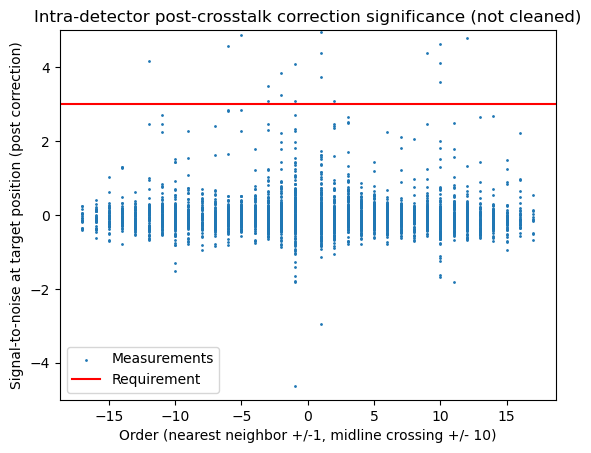

In [13]:
plt.scatter(intra_detector_catalog['order'],
            intra_detector_catalog['target_sn'], s=1, label="Measurements")
plt.axhline(3.0, label="Requirement", c="red")
plt.xlabel("Order (nearest neighbor +/-1, midline crossing +/- 10)")
plt.ylabel("Signal-to-noise at target position (post correction)")
plt.title("Intra-detector post-crosstalk correction significance (not cleaned)")
plt.ylim(-5, 5)
plt.legend()
# plt.savefig("intra_detector_ct.png")
plt.show()

In [14]:
intra_detector_catalog[intra_detector_catalog["target_sn"] > 3.0]

source_exposure,mjd,source_detector,source_amplifier,source_x,source_y,source_flux,source_variance,source_sky,source_sn,order,target_flux,target_variance,target_sky,target_sn
int64,float64,int64,str3,float64,float64,float32,float32,float32,float32,int64,float32,float32,float32,float32
2024120500068,60650.2073910646,2,C12,1348.523211340309,2079.6539173849105,53444.215,62611.38,1.5585327,213.5804,7,644.0149,2176.1094,1.5585327,13.772198
2024120100205,60646.0996711459,6,C16,3261.106410321299,3930.8907574028262,48727.227,58850.406,1.1710956,200.85678,6,1083.8168,2361.4673,1.1710956,22.278982
2024120500057,60650.2020165278,2,C07,3842.4668319361763,451.7010571628516,64386.016,86304.97,1.0604683,219.16264,-5,391.16632,1015.93524,1.0604683,12.2390995
2024112800141,60643.0681870831,7,C17,3751.2054058486647,3474.239146792346,49236.035,55124.004,1.438087,209.70076,3,228.43219,1172.7952,1.438087,6.6283207
2024120700295,60652.1914298609,2,C12,1301.3376730763794,3540.425452205738,55636.254,66889.734,1.4432225,215.11311,-3,10287.345,11724.009,1.4432225,94.99577
2024120500135,60650.2420856827,2,C17,3734.77070721197,2386.6017470129686,61289.63,78242.68,0.9773586,219.10799,14,659.3094,1286.9852,0.9773586,18.350935
2024121000473,60655.2747717709,5,C04,2473.0455854961974,1980.3846384840674,54259.51,65660.06,2.8748217,211.73967,-10,5346.4263,6918.985,2.8748217,64.24048
2024111800102,60633.1029401966,0,C10,68.95469379876795,3832.883187061132,61156.234,73575.91,1.3018205,225.45699,9,763.2628,1804.054,1.3018205,17.939404
2024112600164,60641.1079866667,7,C01,690.7166689325295,1958.227231765104,47086.836,55417.6,1.7893355,200.01341,-10,1036.2803,3154.7131,1.7893355,18.418182


The vast majority of the points fall below the 3-sigma requirement. Spot checking the ones that don't suggests these points are falling on other stars in the field, skewing the measurement. It's notable that the majority of these high S/N points fall "far away" from the source, with the majority being across the midline (and so have much smaller crosstalk coefficients).

There are also negative excursions, and the median level is slightly negative, which is consistent with visual inspection that shows that we are slightly over-subtracting the crosstalk with these coefficients.  This type of failure is not reflected in the verification requirement, which only requires the residuals to be under 3 sigma.

We expect that the initial results with LSSTCam will be consistent with LSSTComCam, although we will be updating the crosstalk coefficients as we commission the telescope and camera.

In [15]:
# Check median value to confirm that we in general find that we're oversubtracting.
np.median(intra_detector_catalog["target_sn"])

np.float32(-0.05585179)

This data can also be used to check the time stability of the crosstalk coefficient, by looking at these residuals as a function of the MJD.

In [16]:
# Bin measurements by integer MJD; bin by day.
# This gives a baseline of 39 days, nearly 3x the stability requirement
binned_x = []
binned_y = []
binned_yp = []
for v in sorted(set(np.floor(intra_detector_catalog['mjd']))):
    binned_x.append(v)
    mask1 = (np.floor(intra_detector_catalog['mjd']) == v)
    binned_y.append(np.median(intra_detector_catalog[mask1]['target_sn']))
    mask2 = mask1 * (np.abs(intra_detector_catalog['order']) <= 1)
    binned_yp.append(np.median(intra_detector_catalog[mask2]['target_sn']))

print(set(np.floor(intra_detector_catalog['mjd'])))

{np.float64(60623.0), np.float64(60624.0), np.float64(60627.0), np.float64(60631.0), np.float64(60632.0), np.float64(60633.0), np.float64(60634.0), np.float64(60635.0), np.float64(60638.0), np.float64(60640.0), np.float64(60641.0), np.float64(60642.0), np.float64(60643.0), np.float64(60644.0), np.float64(60645.0), np.float64(60646.0), np.float64(60647.0), np.float64(60648.0), np.float64(60650.0), np.float64(60651.0), np.float64(60652.0), np.float64(60653.0), np.float64(60654.0), np.float64(60655.0), np.float64(60656.0)}


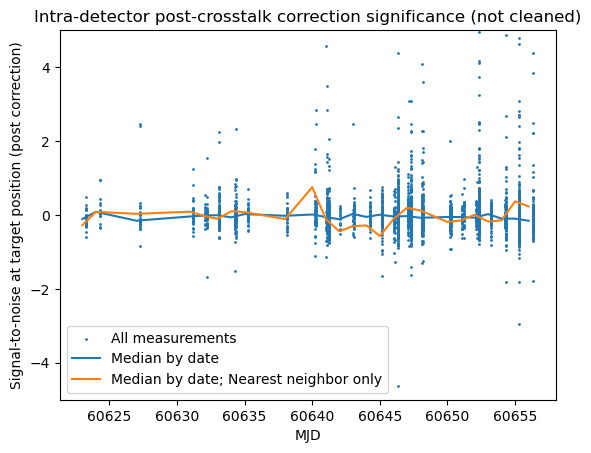

In [17]:
plt.scatter(intra_detector_catalog['mjd'],
            intra_detector_catalog['target_sn'], s=1, label="All measurements")
plt.plot(binned_x, binned_y, label="Median by date")
plt.plot(binned_x, binned_yp, label="Median by date; Nearest neighbor only")
# plt.ylim(-0.005, 0.005)
plt.xlabel("MJD")
plt.ylabel("Signal-to-noise at target position (post correction)")
plt.title("Intra-detector post-crosstalk correction significance (not cleaned)")
plt.ylim(-5, 5)
# plt.savefig("intra_detector_ct_by_time.png")
plt.legend()
plt.show()

There does not appear to be any trend in time with these values, suggesting that the crosstalk is rather stable.

## Results

We have demonstrated that the residuals at positions expected to contain crosstalk signal from bright stars are less than the required limit of **Xtalk < 3 sigma**. Given the demonstrated effectiveness of the crosstalk corrections, we deem this test's result a *Pass*.